In [184]:
# import pandas as pd
# import numpy as np
# import sqlite3
# import nba_api

# # Connect to the SQLite database
# conn = sqlite3.connect('nba.sqlite')

# # Query the game table and load the data into a DataFrame
# query = """
# SELECT *
# FROM game
# """
# games = pd.read_sql_query(query, conn)

# # Close the database connection
# conn.close()

# # 2023 is last year in dataset - use it to get "age"
# team_id_age_arr = np.array([[str(t.get('id')), t.get('year_founded')] for t in nba_api.stats.static.teams.get_teams()])

# # Prepare the data
# df = games.copy()
# msk = (df['team_id_home'].isin(team_id_age_arr[:, 0])) | (df['team_id_away'].isin(team_id_age_arr[:, 0]))

# df = df.drop_duplicates(subset=['game_id'])
# df['game_date'] = pd.to_datetime(df['game_date'])
# df = df.loc[df['season_type'].isin(["Playoffs", "Regular Season"])]
# # Sorting to ensure correct rolling calculation
# df = df.sort_values(by='game_date')

# # Rolling statistics for home team
# rolling_features = ['fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home']
# for feature in rolling_features:
#     df[f'rolling_avg_3_{feature}'] = df.groupby('team_id_home')[feature].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# # Rolling statistics for away team
# for feature in rolling_features:
#     modified_feature = feature.replace('home', 'away')
#     df[f'rolling_avg_3_{modified_feature}'] = df.groupby('team_id_away')[modified_feature].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# # Calculate the differences between rolling averages of home and away teams for comparative analysis
# for feature in rolling_features:
#     home_feature = f'rolling_avg_3_{feature}'
#     away_feature = home_feature.replace('home', 'away')
#     df[f'diff_{feature}'] = df[home_feature] - df[away_feature]

# # Define the outcome variables
# df['home_win'] = (df['wl_home'] == 'W').astype(int)  # 1 if home team won, 0 otherwise
# df['point_diff'] = df['pts_home'] - df['pts_away']  # Point difference of the game

# # Select only the necessary columns for training
# model_features = [col for col in df.columns if 'rolling_avg_3' in col or col in ['home_win', 'point_diff', 'game_date', 'season_id']]
# final_df = df[model_features]

# home_features = [c for c in final_df.columns if "home" in c and not c=="home_win"]
# away_features = [c for c in final_df.columns if "away" in c and not c=="home_win"]

# final_df


,season_id,game_date,rolling_avg_3_fgm_home,rolling_avg_3_fga_home,rolling_avg_3_fg_pct_home,rolling_avg_3_fg3m_home,rolling_avg_3_fg3a_home,rolling_avg_3_fg3_pct_home,rolling_avg_3_ftm_home,rolling_avg_3_fta_home,rolling_avg_3_ft_pct_home,rolling_avg_3_oreb_home,rolling_avg_3_dreb_home,rolling_avg_3_reb_home,rolling_avg_3_ast_home,rolling_avg_3_stl_home,rolling_avg_3_blk_home,rolling_avg_3_tov_home,rolling_avg_3_pf_home,rolling_avg_3_pts_home,rolling_avg_3_fgm_away,rolling_avg_3_fga_away,rolling_avg_3_fg_pct_away,rolling_avg_3_fg3m_away,rolling_avg_3_fg3a_away,rolling_avg_3_fg3_pct_away,rolling_avg_3_ftm_away,rolling_avg_3_fta_away,rolling_avg_3_ft_pct_away,rolling_avg_3_oreb_away,rolling_avg_3_dreb_away,rolling_avg_3_reb_away,rolling_avg_3_ast_away,rolling_avg_3_stl_away,rolling_avg_3_blk_away,rolling_avg_3_tov_away,rolling_avg_3_pf_away,rolling_avg_3_pts_away,home_win,point_diff
0,21946,1946-11-01,25.000000,NaN,NaN,NaN,NaN,NaN,16.000000,29.000000,0.552000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.000000,24.000000,NaN,NaN,NaN,NaN,NaN,20.000000,26.000000,0.769000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.000000,0,-2.0
1,21946,1946-11-02,20.000000,59.000000,0.339000,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,56.000000,16.000000,72.000000,0.222000,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,51.000000,1,5.0
2,21946,1946-11-02,21.000000,NaN,NaN,NaN,NaN,NaN,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.000000,21.000000,NaN,NaN,NaN,NaN,NaN,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,1,6.0
3,21946,1946-11-02,21.000000,NaN,NaN,NaN,NaN,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,63.000000,20.000000,NaN,NaN,NaN,NaN,NaN,17.500000,26.000000,0.769000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,57.500000,1,16.0
4,21946,1946-11-02,10.000000,NaN,NaN,NaN,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,18.000000,NaN,NaN,NaN,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,0,-17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65691,42022,2023-06-01,43.000000,86.333333,0.497667,12.333333,32.333333,0.377667,16.333333,20.000000,0.820667,10.666667,36.333333,47.000000,28.333333,5.666667,4.333333,12.666667,15.666667,114.666667,40.333333,86.666667,0.469000,12.000000,30.000000,0.408000,5.000000,6.000000,0.877667,9.333333,31.000000,40.333333,24.000000,6.000000,2.666667,12.666667,14.333333,97.666667,1,11.0
65692,42022,2023-06-04,39.333333,81.000000,0.488000,11.000000,31.000000,0.352333,17.000000,20.000000,0.851000,8.666667,35.333333,44.000000,26.333333,6.333333,2.666667,13.666667,15.666667,106.666667,39.666667,86.666667,0.460333,14.666667,34.000000,0.439667,8.333333,9.333333,0.911000,8.666667,30.000000,38.666667,26.666667,5.666667,3.333333,11.000000,17.333333,102.333333,0,-3.0
65693,42022,2023-06-07,33.666667,87.666667,0.387000,11.000000,32.333333,0.343667,20.333333,25.333333,0.801000,13.000000,28.333333,41.333333,20.000000,5.666667,3.000000,8.333333,21.333333,98.666667,42.000000,84.333333,0.498333,11.333333,30.666667,0.352333,18.333333,22.666667,0.805333,9.666667,36.000000,45.666667,27.666667,4.333333,5.000000,10.333333,19.000000,113.666667,0,-15.0
65694,42022,2023-06-09,34.000000,87.666667,0.391333,11.000000,30.000000,0.367000,18.333333,22.666667,0.810667,11.666667,27.333333,39.000000,21.666667,4.666667,3.333333,8.000000,21.666667,97.333333,40.333333,81.333333,0.496333,10.333333,26.333333,0.380667,19.000000,23.333333,0.813667,9.666667,34.333333,44.000000,26.333333,5.666667,7.000000,11.000000,18.666667,110.000000,0,-13.0


In [4]:
import nba_api.stats
import nba_api.stats.static
import nba_api.stats.static.teams
import pandas as pd
import numpy as np
import sqlite3
import nba_api

# Connect to the SQLite database
conn = sqlite3.connect('nba.sqlite')

# Query the game table and load the data into a DataFrame
query = """
SELECT *
FROM game
"""
games = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# 2023 is last year in dataset - use it to get "age"
print(nba_api.stats.static.teams.get_teams())
team_id_age_arr = np.array([[str(t.get('id')), t.get('year_founded')] for t in nba_api.stats.static.teams.get_teams()])

# Prepare the data
df = games.copy()
msk = (df['team_id_home'].isin(team_id_age_arr[:, 0])) | (df['team_id_away'].isin(team_id_age_arr[:, 0]))

df = df.drop_duplicates(subset=['game_id'])
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.loc[df['season_type'].isin(["Playoffs", "Regular Season"])]
# Sorting to ensure correct rolling calculation
df = df.sort_values(by='game_date')

# Calculate days since last game for home and away teams
df['days_since_last_game_home'] = df.groupby('team_id_home')['game_date'].diff().dt.days
df['days_since_last_game_away'] = df.groupby('team_id_away')['game_date'].diff().dt.days

# Calculate team age at time of game
team_age_df = pd.DataFrame(team_id_age_arr, columns=['team_id', 'year_founded'])
team_age_df['year_founded'] = team_age_df['year_founded'].astype(int)

df = df.merge(team_age_df, left_on='team_id_home', right_on='team_id', how='left')
df['team_age_at_game_home'] = df['game_date'].dt.year - df['year_founded']
df = df.drop(columns=['team_id', 'year_founded'])

df = df.merge(team_age_df, left_on='team_id_away', right_on='team_id', how='left')
df['team_age_at_game_away'] = df['game_date'].dt.year - df['year_founded']
df = df.drop(columns=['team_id', 'year_founded'])

# Rolling statistics for home team
rolling_features = ['fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home']
for feature in rolling_features:
    df[f'rolling_avg_3_{feature}'] = df.groupby('team_id_home')[feature].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Rolling statistics for away team
for feature in rolling_features:
    modified_feature = feature.replace('home', 'away')
    df[f'rolling_avg_3_{modified_feature}'] = df.groupby('team_id_away')[modified_feature].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Calculate the differences between rolling averages of home and away teams for comparative analysis
for feature in rolling_features:
    home_feature = f'rolling_avg_3_{feature}'
    away_feature = home_feature.replace('home', 'away')
    df[f'diff_{feature}'] = df[home_feature] - df[away_feature]

# Define the outcome variables
df['home_win'] = (df['wl_home'] == 'W').astype(int)  # 1 if home team won, 0 otherwise
df['point_diff'] = df['pts_home'] - df['pts_away']  # Point difference of the game

# Select only the necessary columns for training
model_features = [col for col in df.columns if 'rolling_avg_3' in col or col in ['home_win', 'point_diff', 'game_date', 'season_id', 'days_since_last_game_home', 'days_since_last_game_away', 'team_age_at_game_home', 'team_age_at_game_away']]
final_df = df[model_features]

home_features = [c for c in final_df.columns if "home" in c and not c=="home_win"]
away_features = [c for c in final_df.columns if "away" in c and not c=="home_win"]
print(home_features)
final_df

[{'id': 1610612737, 'full_name': 'Atlanta Hawks', 'abbreviation': 'ATL', 'nickname': 'Hawks', 'city': 'Atlanta', 'state': 'Georgia', 'year_founded': 1949}, {'id': 1610612738, 'full_name': 'Boston Celtics', 'abbreviation': 'BOS', 'nickname': 'Celtics', 'city': 'Boston', 'state': 'Massachusetts', 'year_founded': 1946}, {'id': 1610612739, 'full_name': 'Cleveland Cavaliers', 'abbreviation': 'CLE', 'nickname': 'Cavaliers', 'city': 'Cleveland', 'state': 'Ohio', 'year_founded': 1970}, {'id': 1610612740, 'full_name': 'New Orleans Pelicans', 'abbreviation': 'NOP', 'nickname': 'Pelicans', 'city': 'New Orleans', 'state': 'Louisiana', 'year_founded': 2002}, {'id': 1610612741, 'full_name': 'Chicago Bulls', 'abbreviation': 'CHI', 'nickname': 'Bulls', 'city': 'Chicago', 'state': 'Illinois', 'year_founded': 1966}, {'id': 1610612742, 'full_name': 'Dallas Mavericks', 'abbreviation': 'DAL', 'nickname': 'Mavericks', 'city': 'Dallas', 'state': 'Texas', 'year_founded': 1980}, {'id': 1610612743, 'full_name':

,season_id,game_date,days_since_last_game_home,days_since_last_game_away,team_age_at_game_home,team_age_at_game_away,rolling_avg_3_fgm_home,rolling_avg_3_fga_home,rolling_avg_3_fg_pct_home,rolling_avg_3_fg3m_home,...,rolling_avg_3_dreb_away,rolling_avg_3_reb_away,rolling_avg_3_ast_away,rolling_avg_3_stl_away,rolling_avg_3_blk_away,rolling_avg_3_tov_away,rolling_avg_3_pf_away,rolling_avg_3_pts_away,home_win,point_diff
0,21946,1946-11-01,NaN,NaN,NaN,0.0,25.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.000000,0,-2.0
1,21946,1946-11-02,NaN,NaN,NaN,NaN,20.000000,59.000000,0.339000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,51.000000,1,5.0
2,21946,1946-11-02,NaN,NaN,NaN,0.0,21.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,1,6.0
3,21946,1946-11-02,NaN,1.0,NaN,0.0,21.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,57.500000,1,16.0
4,21946,1946-11-02,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,0,-17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64029,42022,2023-06-01,14.0,3.0,47.0,35.0,43.000000,86.333333,0.497667,12.333333,...,31.000000,40.333333,24.000000,6.000000,2.666667,12.666667,14.333333,97.666667,1,11.0
64030,42022,2023-06-04,3.0,3.0,47.0,35.0,39.333333,81.000000,0.488000,11.000000,...,30.000000,38.666667,26.666667,5.666667,3.333333,11.000000,17.333333,102.333333,0,-3.0
64031,42022,2023-06-07,11.0,16.0,35.0,47.0,33.666667,87.666667,0.387000,11.000000,...,36.000000,45.666667,27.666667,4.333333,5.000000,10.333333,19.000000,113.666667,0,-15.0
64032,42022,2023-06-09,2.0,2.0,35.0,47.0,34.000000,87.666667,0.391333,11.000000,...,34.333333,44.000000,26.333333,5.666667,7.000000,11.000000,18.666667,110.000000,0,-13.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 20)        │         41 │ home_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 20)        │         41 │ away_input[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      5,248 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_win (Dense)    │ (None, 1)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point_diff (Dense)  │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,732 (61.46 KB)

 Trainable params: 15,650 (61.13 KB)

 Non-trainable params: 82 (336.00 B)

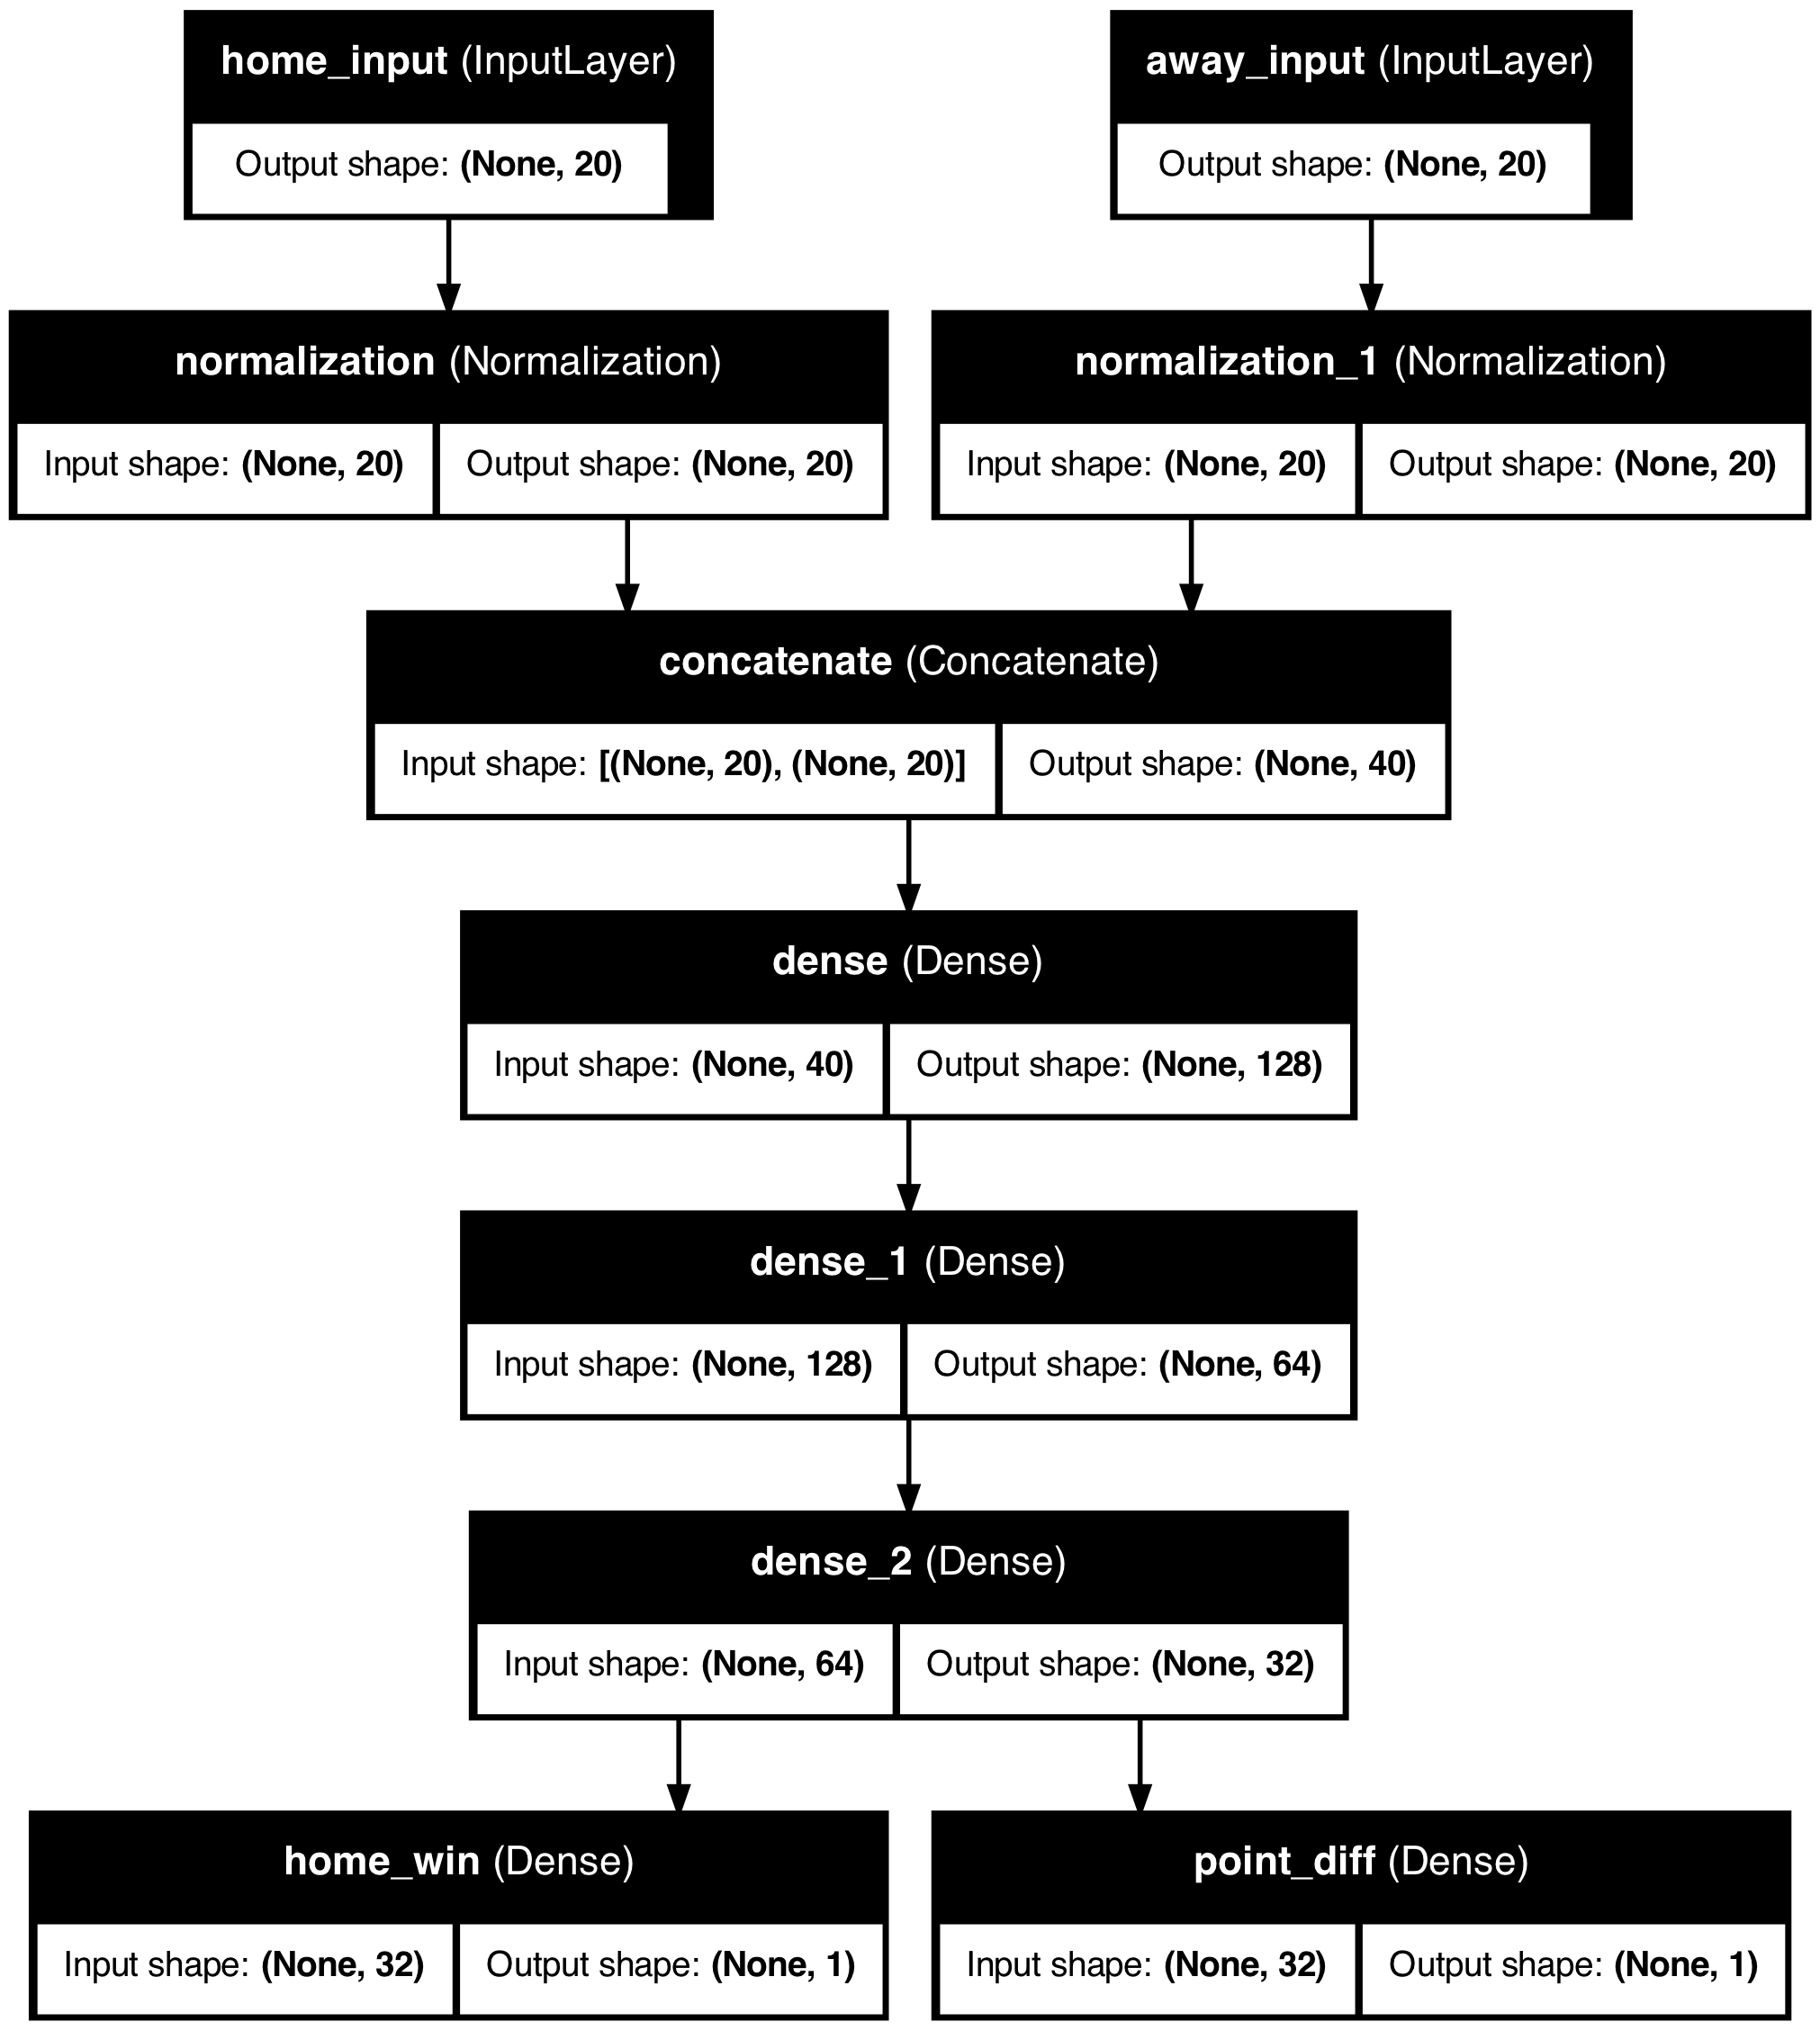

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization
from tensorflow.keras.utils import plot_model

train_df = final_df.copy()

# Assuming df is your DataFrame loaded from the SQLite database
# Fill NaN values with the mean of each column (or choose another method)
train_df[home_features] = train_df[home_features].apply(lambda x: x.fillna(x.mean()), axis=0)
train_df[away_features] = train_df[away_features].apply(lambda x: x.fillna(x.mean()), axis=0)

# Normalize the input features
normalizer_home = Normalization(axis=-1)
normalizer_home.adapt(train_df[home_features].to_numpy())

normalizer_away = Normalization(axis=-1)
normalizer_away.adapt(train_df[away_features].to_numpy())

# Define model inputs
home_input = Input(shape=(len(home_features),), name="home_input")
away_input = Input(shape=(len(away_features),), name="away_input")

# Apply normalization
norm_home = normalizer_home(home_input)
norm_away = normalizer_away(away_input)

# Concatenate the inputs
concatenated = Concatenate()([norm_home, norm_away])

# Define the rest of the model
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense3)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense3)

# Create the model
model = Model(inputs=[home_input, away_input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mae'})

# Model summary
model.summary()

# Visualize the model structure
plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - home_win_accuracy: 0.7891 - loss: 82.5410 - point_diff_mae: 7.1358 - val_home_win_accuracy: 0.7444 - val_loss: 106.6256 - val_point_diff_mae: 8.1694
Epoch 2/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - home_win_accuracy: 0.7865 - loss: 81.4867 - point_diff_mae: 7.0711 - val_home_win_accuracy: 0.7457 - val_loss: 105.6099 - val_point_diff_mae: 8.0984
Epoch 3/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - home_win_accuracy: 0.7859 - loss: 80.6608 - point_diff_mae: 7.0132 - val_home_win_accuracy: 0.7438 - val_loss: 107.3351 - val_point_diff_mae: 8.1869
Epoch 4/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - home_win_accuracy: 0.7893 - loss: 80.8882 - point_diff_mae: 7.0432 - val_home_win_accuracy: 0.7451 - val_loss: 108.7531 - val_point_diff_mae: 8.2212
Epoch 5/20
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - home_win_accuracy: 0.7901 - loss: 79.8196 - point_diff_mae: 6.9968 - val_home_win_accuracy: 0.7446 - val_loss: 108

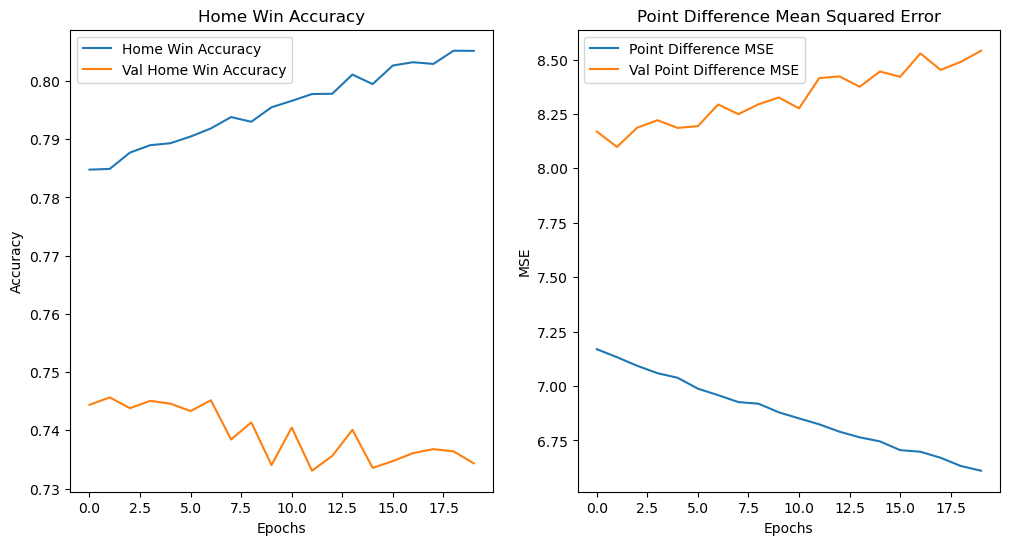

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare data for training
X_home = train_df[home_features].to_numpy()
X_away = train_df[away_features].to_numpy()
y_home_win = train_df['home_win'].to_numpy()
y_point_diff = train_df['point_diff'].to_numpy()

# Split the data into training and testing sets (80/20 split)
X_home_train, X_home_test, X_away_train, X_away_test, y_home_win_train, y_home_win_test, y_point_diff_train, y_point_diff_test = train_test_split(
    X_home, X_away, y_home_win, y_point_diff, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    [X_home_train, X_away_train], {'home_win': y_home_win_train, 'point_diff': y_point_diff_train},
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_results = model.evaluate([X_home_test, X_away_test], {'home_win': y_home_win_test, 'point_diff': y_point_diff_test}, verbose=1)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['home_win_accuracy'], label='Home Win Accuracy')
    plt.plot(history.history['val_home_win_accuracy'], label='Val Home Win Accuracy')
    plt.title('Home Win Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['point_diff_mae'], label='Point Difference MSE')
    plt.plot(history.history['val_point_diff_mae'], label='Val Point Difference MSE')
    plt.title('Point Difference Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    plt.show()

plot_history(history)

In [115]:
test_results

[107.17404174804688, 0.7464391589164734, 106.65536499023438]

In [96]:
df['season_id'].value_counts()

season_id
22016    1230
22004    1230
22018    1230
22008    1230
22015    1230
         ... 
32004       1
31975       1
32003       1
31976       1
32022       1
Name: count, Length: 225, dtype: int64

In [98]:
df[df['season_id']=='22008']

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
46559,22008,1610612738,BOS,Boston Celtics,0020800001,2008-10-28,BOS vs. CLE,W,240,33.0,74.0,0.446,3.0,14.0,0.214,21.0,34.0,0.618,10.0,26.0,36.0,16.0,10.0,0.0,17.0,28.0,90.0,5,0,1610612739,CLE,Cleveland Cavaliers,CLE @ BOS,L,29.0,68.0,0.426,3.0,15.0,0.200,24.0,33.0,0.727,8.0,33.0,41.0,16.0,8.0,2.0,22.0,26.0,85.0,-5,0,Regular Season
46560,22008,1610612747,LAL,Los Angeles Lakers,0020800003,2008-10-28,LAL vs. POR,W,240,37.0,79.0,0.468,7.0,10.0,0.700,15.0,18.0,0.833,9.0,40.0,49.0,19.0,8.0,7.0,15.0,17.0,96.0,20,0,1610612757,POR,Portland Trail Blazers,POR @ LAL,L,29.0,84.0,0.345,10.0,24.0,0.417,8.0,14.0,0.571,13.0,31.0,44.0,19.0,8.0,3.0,14.0,17.0,76.0,-20,0,Regular Season
46561,22008,1610612741,CHI,Chicago Bulls,0020800002,2008-10-28,CHI vs. MIL,W,240,35.0,69.0,0.507,5.0,12.0,0.417,33.0,44.0,0.750,14.0,26.0,40.0,27.0,9.0,6.0,19.0,18.0,108.0,13,0,1610612749,MIL,Milwaukee Bucks,MIL @ CHI,L,37.0,78.0,0.474,6.0,14.0,0.429,15.0,20.0,0.750,13.0,19.0,32.0,21.0,5.0,3.0,19.0,30.0,95.0,-13,0,Regular Season
46562,22008,1610612752,NYK,New York Knicks,0020800007,2008-10-29,NYK vs. MIA,W,240,42.0,87.0,0.483,9.0,25.0,0.360,27.0,37.0,0.730,14.0,32.0,46.0,27.0,7.0,0.0,15.0,28.0,120.0,5,0,1610612748,MIA,Miami Heat,MIA @ NYK,L,42.0,92.0,0.457,6.0,23.0,0.261,25.0,33.0,0.758,13.0,34.0,47.0,22.0,8.0,2.0,14.0,26.0,115.0,-5,0,Regular Season
46563,22008,1610612753,ORL,Orlando Magic,0020800004,2008-10-29,ORL vs. ATL,L,240,32.0,87.0,0.368,4.0,25.0,0.160,17.0,27.0,0.630,17.0,28.0,45.0,10.0,9.0,11.0,15.0,28.0,85.0,-14,0,1610612737,ATL,Atlanta Hawks,ATL @ ORL,W,38.0,86.0,0.442,5.0,20.0,0.250,18.0,31.0,0.581,18.0,35.0,53.0,17.0,10.0,7.0,15.0,23.0,99.0,14,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47784,22008,1610612738,BOS,Boston Celtics,0020801217,2009-04-15,BOS vs. WAS,W,240,45.0,85.0,0.529,10.0,18.0,0.556,15.0,24.0,0.625,12.0,29.0,41.0,29.0,6.0,2.0,16.0,25.0,115.0,8,0,1610612764,WAS,Washington Wizards,WAS @ BOS,L,38.0,77.0,0.494,7.0,20.0,0.350,24.0,30.0,0.800,8.0,27.0,35.0,15.0,9.0,8.0,14.0,26.0,107.0,-8,0,Regular Season
47785,22008,1610612739,CLE,Cleveland Cavaliers,0020801219,2009-04-15,CLE vs. PHI,L,265,46.0,89.0,0.517,10.0,24.0,0.417,8.0,12.0,0.667,14.0,22.0,36.0,26.0,6.0,5.0,18.0,31.0,110.0,-1,0,1610612755,PHI,Philadelphia 76ers,PHI @ CLE,W,38.0,72.0,0.528,3.0,9.0,0.333,32.0,43.0,0.744,11.0,25.0,36.0,18.0,12.0,5.0,16.0,17.0,111.0,1,0,Regular Season
47786,22008,1610612752,NYK,New York Knicks,0020801225,2009-04-15,NYK vs. NJN,W,240,38.0,85.0,0.447,7.0,24.0,0.292,19.0,22.0,0.864,14.0,35.0,49.0,17.0,9.0,4.0,10.0,17.0,102.0,29,0,1610612751,NJN,New Jersey Nets,NJN @ NYK,L,26.0,83.0,0.313,4.0,13.0,0.308,17.0,19.0,0.895,20.0,29.0,49.0,12.0,6.0,6.0,20.0,19.0,73.0,-29,0,Regular Season
47787,22008,1610612763,MEM,Memphis Grizzlies,0020801222,2009-04-15,MEM vs. ATL,W,240,37.0,73.0,0.507,3.0,8.0,0.375,21.0,31.0,0.677,7.0,36.0,43.0,19.0,9.0,10.0,11.0,16.0,98.0,8,0,1610612737,ATL,Atlanta Hawks,ATL @ MEM,L,33.0,76.0,0.434,6.0,17.0,0.353,18.0,24.0,0.750,8.0,32.0,40.0,13.0,2.0,4.0,14.0,27.0,90.0,-8,0,Regular Season


In [92]:
def calculate_offensive_efficiency(df):
    df['offensive_efficiency_home'] = (df['fgm_home'] + df['ast_home']) / (df['fga_home'] - df['oreb_home'] + df['ast_home'] + df['tov_home'])
    df['offensive_efficiency_away'] = (df['fgm_away'] + df['ast_away']) / (df['fga_away'] - df['oreb_away'] + df['ast_away'] + df['tov_away'])
    return df

def calculate_win_percentages(df):
    df['home_flag'] = np.where(df['wl_home'] == 'W', 1, 0)
    df['away_flag'] = np.where(df['wl_away'] == 'W', 1, 0)

    df['home_games_played'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['home_flag'].cumsum()
    df['home_wins'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['home_flag'].cumsum()
    df['home_win_pctg'] = df['home_wins'] / df['home_games_played']

    df['away_games_played'] = df.sort_values('game_date').groupby(['team_id_away', 'season_id'])['away_flag'].cumsum()
    df['away_wins'] = df.sort_values('game_date').groupby(['team_id_away', 'season_id'])['away_flag'].cumsum()
    df['away_win_pctg'] = df['away_wins'] / df['away_games_played']

    df['total_games_played'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['game_id'].cumcount() + 1
    df['total_wins'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['home_flag'].cumsum()
    df['total_win_pctg'] = df['total_wins'] / df['total_games_played']
    return df

def calculate_rolling_metrics(df):
    df['rolling_oe'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['offensive_efficiency_home'].transform(lambda x: x.rolling(3, 1).mean())
    df['rolling_scoring_margin'] = df['pts_home'] - df['pts_away']
    df['rolling_scoring_margin'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['rolling_scoring_margin'].transform(lambda x: x.rolling(3, 1).mean())
    return df

def calculate_rest_days(df):
    df['last_game_date'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['game_date'].shift(1)
    df['num_rest_days'] = (df['game_date'] - df['last_game_date']).dt.days
    return df

def shift_game_log_records(df):
    df['last_game_oe'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['offensive_efficiency_home'].shift(1)
    df['last_game_home_win_pctg'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['home_win_pctg'].shift(1)
    df['last_game_away_win_pctg'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['away_win_pctg'].shift(1)
    df['last_game_total_win_pctg'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['total_win_pctg'].shift(1)
    df['last_game_rolling_scoring_margin'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['rolling_scoring_margin'].shift(1)
    df['last_game_rolling_oe'] = df.sort_values('game_date').groupby(['team_id_home', 'season_id'])['rolling_oe'].shift(1)
    return df

def get_home_team_frame(df):
    home_team_frame = df[['last_game_oe', 'last_game_home_win_pctg', 'num_rest_days', 'last_game_away_win_pctg',
                          'last_game_total_win_pctg', 'last_game_rolling_scoring_margin', 'last_game_rolling_oe',
                          'home_flag', 'team_id_home', 'game_id', 'season_id']]

    home_team_frame.columns = ['home_' + col if col != 'game_id' and col != 'season_id' else col for col in home_team_frame.columns]
    return home_team_frame

def get_away_team_frame(df):
    away_team_frame = df[['last_game_oe', 'last_game_home_win_pctg', 'num_rest_days', 'last_game_away_win_pctg',
                          'last_game_total_win_pctg', 'last_game_rolling_scoring_margin', 'last_game_rolling_oe',
                          'team_id_away', 'game_id', 'season_id']]

    away_team_frame.columns = ['away_' + col if col != 'game_id' and col != 'season_id' else col for col in away_team_frame.columns]
    return away_team_frame

def get_game_log_feature_set(df):
    df = calculate_offensive_efficiency(df)
    df = calculate_win_percentages(df)
    df = calculate_rolling_metrics(df)
    df = calculate_rest_days(df)
    df = shift_game_log_records(df)

    home_team_frame = get_home_team_frame(df)
    away_team_frame = get_away_team_frame(df)

    feature_set = pd.merge(home_team_frame, away_team_frame, on=['game_id', 'season_id'])
    feature_set = feature_set.drop(['game_id', 'away_team_id_away', 'home_team_id_home'], axis=1)

    return feature_set


In [94]:
game_logs = df.copy()
model_data = get_game_log_feature_set(game_logs)
model_data

,home_last_game_oe,home_last_game_home_win_pctg,home_num_rest_days,home_last_game_away_win_pctg,home_last_game_total_win_pctg,home_last_game_rolling_scoring_margin,home_last_game_rolling_oe,home_home_flag,season_id,away_last_game_oe,away_last_game_home_win_pctg,away_num_rest_days,away_last_game_away_win_pctg,away_last_game_total_win_pctg,away_last_game_rolling_scoring_margin,away_last_game_rolling_oe
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,21946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,21946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,21946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65637,0.616071,1.0,3.0,1.0,1.000000,7.333333,0.612697,0,42022,0.616071,1.0,3.0,1.0,1.000000,7.333333,0.612697
65638,0.533981,1.0,11.0,1.0,0.750000,2.666667,0.557124,0,42022,0.533981,1.0,11.0,1.0,0.750000,2.666667,0.557124
65639,0.509434,1.0,2.0,1.0,0.666667,-11.000000,0.521138,0,42022,0.509434,1.0,2.0,1.0,0.666667,-11.000000,0.521138
65640,0.601942,1.0,8.0,1.0,0.900000,4.333333,0.586332,1,42022,0.601942,1.0,8.0,1.0,0.900000,4.333333,0.586332
